# Chapter 5. ESNの力学系的解析

この章では、RCを理解する上で重要となる力学系 (dynamical systems) に関する基礎知識を学びます。
その上で、力学系の観点からESNの解析を行い、エコーステート性 (Echo State Property; ESP) との関連性を学びます。

## 前書き

**力学系**<sup>[1, 2]</sup>とは、一定の**規則**にしたがって時間の経過とともに**状態**が変化する系を指します。
離散時間 $t \in \mathbb{Z}$ で定義される力学系は**離散力学系**と呼ばれ、その時間発展は $N$ 次元の状態 $x \in \mathbb{R}^N$ と写像 $f: \mathbb{R}^N \to \mathbb{R}^N$ を用いた差分方程式で表されます。

$$
\begin{align*}
x[k+1] = f(x[k]) \tag{I}
.\end{align*}
$$

一方、連続時間 $t \in \mathbb{R}$ で定義される力学系は**連続力学系**と呼ばれ、その時間発展は次の形の微分方程式で表されます。

$$
\begin{align*}
\frac{dx}{dt}(t) = f(x(t)) \tag{II}
.\end{align*}
$$

いずれの場合においても、原則として力学系の発展規則は決定論的であり、未来の状態は現在の状態から一意的に決められます。
したがって、 初期状態 $x[0]$ あるいは $x(0)$ さえ判明すれば、(未来の) 任意の時刻における状態 $x$ を式 $(\mathrm{I})$ や式 $(\mathrm{II})$ の繰り返し計算によって求められます。
そのような状態 $x$ の時間発展は **軌道**とも呼ばれます。
また状態 $x$ が取りうる値の全てからなる集合は **位相空間** (phase space) と呼ばれ、この定式化では $\mathbb{R}^N$ が位相空間に対応します。

これまで学んできたESNも内部状態が一定の規則にしたがって時間発展する系であり、入力を考慮しなければ上記の力学系の式として定式化できます。
したがって、力学系の分野で使われてきた数々の解析手法は、ESNの挙動を理解したり分析するのに役に立ちます。
本章では、特に次のようなトピックを扱い、力学系としてのESNの理解の深化を目的とします。
- ESNを長時間走らせたらどんな振る舞いに収束するか？ (アトラクタ)
- ESNのパラメータを変化させるとその挙動はどう変化するか？ (分岐)
- ESNの挙動はその初期状態にどう依存するのか？ (カオス・リアプノフ指数)
- ESNの情報処理能力を十分に活用できる条件は？ (入力つき力学系の性質・ESP)

## 演習問題と実演

前回と同様、各種ライブラリおよび実装済みの`ESN`・`Linear`の`import`を行うために次のセルを実行してください。なお`ESN`・`Linear`の内部実装を再確認するには、`import inspect`以下の行をコメントアウトするか`...?? / ??...`を使用してください。

In [ ]:
import sys

import matplotlib.patches as patches
import numpy as np

if "google.colab" in sys.modules:
    from google.colab import drive  # type: ignore

    if False:  # Set to True if you want to use Google Drive and save your work there.
        drive.mount("/content/gdrive")
        %cd /content/gdrive/My Drive/rc-bootcamp/
        # NOTE: Change it to your own path if you put the zip file elsewhere.
        # e.g., %cd /content/gdrive/My Drive/[PATH_TO_EXTRACT]/rc-bootcamp/
    else:
        pass
        %cd /content/
        !git clone --branch ja_sol https://github.com/rc-bootcamp/rc-bootcamp.git
        %cd /content/rc-bootcamp/
else:
    sys.path.append(".")

from utils.reservoir import ESN, Linear
from utils.style_config import Figure, plt
from utils.tester import load_from_chapter_name
from utils.tqdm import tqdm, trange
from utils.viewer import show_3d_coord

test_func, show_solution = load_from_chapter_name("05_esn_dynamics")

# Uncomment it to see the implementations of `Linear` and `ESN`.
# import inspect
# print(inspect.getsource(Linear))
# print(inspect.getsource(ESN))

# Or just use ??.../...?? (uncomment the following lines).
# Linear??
# ESN??

### 1. アトラクタの種類

ある力学系を時間発展させたとき、その状態が最終的に引き付けられる相空間上の領域を**アトラクタ** (attractor) といいます。
ひとたび系の軌道がアトラクタに引き込まれると、わずかな摂動を受けてもアトラクタ内にとどまるようになります。
力学系にアトラクタが存在するとき、ある程度の時間が経過すると系の状態はアトラクタにほとんど引き込まれるため、アトラクタ上での振る舞いが実質的に系の長期的な振る舞いを支配しているといえます。
したがって、力学系の分野においては、アトラクタの性質やその解析が特に重要視されています。

エノン写像 (Hénon map) は、1976年にフランスの天文学者 M. Hénon により考案された2次元の離散力学系です。
この系はパラメータの値に応じて異なる種類のアトラクタに収束し、単純な式で表現されるのにも関わらず複雑な挙動を示す場合があります。
具体的には、エノン写像の時間発展は以下の式で表されます。

$$
\begin{align*}
x[k+1] &= 1 - a x[k]^2 + y[k] \\
y[k+1] &= bx[k]
.\end{align*}
$$

- $k \in \mathbb{Z}$: 離散時間
- $x[k], y[k] \in \mathbb{R}$: 系の状態
- $a, b \in \mathbb{R}$: パラメータ (定数)

Q1.1.

以下の穴埋めを実装し、エノン写像について現在時刻の状態から次時刻の状態を求める関数`henon_func`を実装せよ。
ただし系の状態は1つの変数にまとめて $z := [x \quad y]^\top \in \mathbb{R}^2$ とし、多数の状態$z$をまとめた多次元配列 $Z \in \mathbb{R}^{... \times 2}$ に対するバッチ処理が可能となるように`henon_func`を実装する。

- `henon_func`
  - Argument(s):
    - `z`: `np.ndarray`
      - `shape`: `(..., 2)`
  - Return(s):
    - `z_out`: `np.ndarray`
      - `shape`: `(..., 2)`

In [ ]:
def henon_func(z, a=1.4, b=0.3):
    assert z.shape[-1] == 2
    z_out = np.zeros_like(z)
    z_out[..., 0] = 1.0 - a * (z[..., 0] ** 2) + z[..., 1]  # TODO
    z_out[..., 1] = b * z[..., 0]  # TODO
    return z_out


test_func(henon_func, "01_01")
# show_solution("01_01", "henon_func")  # Uncomment it to see the solution.

#### 固定点

アトラクタの分類として、まず挙げられるのが固定点 (fixed point) です。
固定点とは、時間変化しても相空間上で動かない点を指し、離散力学系の場合は $x[k+1] = x[k]$ すなわち $x^* = f(x^*)$ を満たす点 $x^*$ に対応します。
周囲の軌道が固定点に引き込まれる安定な固定点と、そうではない不安定な固定点が存在し、このうち前者がアトラクタに該当します。

エノン写像はパラメータの値が $a=0, b=0.3$ のとき1つの固定点をアトラクタとして持ちます。
以下はその固定点と、そこに至るまでのダイナミクスを表示するコードです。

In [ ]:
a, b = 0.0, 0.3
length = 21
z0 = np.array([1.2, 1.0])

ts = np.arange(length)
zs = np.zeros((length + 1, 2))
zs[0] = z0
for idx in ts:
    zs[idx + 1] = henon_func(zs[idx], a, b)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [1, 2], "wspace": 0.3})

ax[0].plot(zs[:, 0], zs[:, 1], marker=".", markersize=10.0, lw=1)
ax[0].plot(10.0 / 7.0, 3.0 / 7.0, marker="*", markersize=15.0, color="red", alpha=0.7)
# ax[0].set_aspect('equal')
ax[1].plot(ts, zs[:-1, 0], marker=".", markersize=10.0, lw=1)
ax[1].axhline(10.0 / 7.0, lw=2.0, color="red", alpha=0.7)
ax[0].set_xlabel(r"$x[k]$")
ax[0].set_ylabel(r"$y[k]$")
ax[1].set_xlabel(r"Time $k$")
ax[1].set_ylabel(r"$x[k]$")

None

#### リミットサイクル

リミットサイクル (limit cycle) とは、相空間上の孤立した周期軌道 (閉軌道) で、固定点と同様に安定なものと不安定なものが存在します。
このうち安定なものがアトラクタに該当します。
「孤立した」とは、その近傍に他の周期軌道が存在しない状況を意味し、換言すれば安定なリミットサイクルの近くにある軌道は最終的に全てそのリミットサイクルに吸引されます。
逆に、不安定なリミットサイクルの近くにある軌道は全て離れていきます。

リミットサイクルは自励振動を示す系、すなわち外からの入力がなくても振動を続ける系のモデルとして科学的にも重要です。
例えば、心臓の拍動は常に概ね一定のリズムを保つ必要があるので、リミットサイクルとしてモデル化できます。
音楽のリズムを刻むのに使われるメトロノームも、リミットサイクルのわかりやすい一例です。

エノン写像はパラメータの値が $a=0.95, b=0.3$ のとき周期 $4$ のリミットサイクルをアトラクタとして持ちます。
以下はそのダイナミクスを表示するコードです。左図がアトラクタ部分のみを $xy$ 平面上で図示したもの、右図がそこに至るまでの $x[k]$ の軌道を示したものです。

In [ ]:
a, b = 0.95, 0.3
length = 100
z0 = np.array([1.0, 1.0])

ts = np.arange(length)
zs = np.zeros((length + 1, 2))
zs[0] = z0
for idx in ts:
    zs[idx + 1] = henon_func(zs[idx], a, b)

plot_length = 32
fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [1, 2], "wspace": 0.3})
ax[0].plot(zs[-plot_length:, 0], zs[-plot_length:, 1], marker=".", markersize=10.0, lw=1)
# ax[0].set_aspect('equal')
ax[1].plot(ts[:plot_length], zs[:plot_length, 0], marker=".", markersize=10.0, lw=1)
ax[0].set_xlabel(r"$x[k]$")
ax[0].set_ylabel(r"$y[k]$")
ax[1].set_xlabel(r"Time $k$")
ax[1].set_ylabel(r"$x[k]$")

None

#### ストレンジアトラクタ

固定点にもリミットサイクルにも分類できず、初期状態に対して鋭敏な依存性を持つアトラクタをストレンジアトラクタ (strange attractor) といいます。
初期状態への鋭敏性、すなわち系の初期状態をわずかに変えたときにその後の軌道が大きくずれてしまう性質は**カオス** (chaos) の重要な特徴で、ストレンジアトラクタも多くの場合初期値鋭敏性を示します。

エノン写像はパラメータの値が $a=1.4, b=0.3$ のとき特徴的なストレンジアトラクタを持ちます。以下はそのアトラクタに至った後の軌道を図示するコードです。

In [ ]:
a, b = 1.4, 0.3
length = 100000
z0 = np.array([1.0, 1.0])

ts = np.arange(length)
zs = np.zeros((length + 1, 2))
zs[0] = z0
for idx in ts:
    zs[idx + 1] = henon_func(zs[idx], a, b)

washout = 100
plot_length = 100
rect1 = patches.Rectangle((0.55, 0.16), 0.15, 0.05, lw=1, edgecolor="red", facecolor="none", zorder=2)
rect2 = patches.Rectangle((0.62, 0.185), 0.02, 0.006, lw=1, edgecolor="red", facecolor="none", zorder=2)
fig, ax = plt.subplots(2, 2, figsize=(9, 9), gridspec_kw={"wspace": 0.45, "hspace": 0.3})

ax[0, 0].plot(zs[washout:, 0], zs[washout:, 1], "b.", markersize=1.0)
ax[0, 0].add_patch(rect1)

plot_range = slice(washout, washout + plot_length)
ax[0, 1].plot(ts[plot_range], zs[plot_range, 0])

ax[1, 0].plot(zs[washout:, 0], zs[washout:, 1], "b.", markersize=2.0)
ax[1, 0].set_xlim(0.55, 0.70)
ax[1, 0].set_ylim(0.16, 0.21)
ax[1, 0].add_patch(rect2)

ax[1, 1].plot(zs[washout:, 0], zs[washout:, 1], "b.", markersize=4.0)
ax[1, 1].set_xlim(0.62, 0.64)
ax[1, 1].set_ylim(0.185, 0.191)

for i, j in [(0, 0), (1, 0), (1, 1)]:
    ax[i, j].set_xlabel(r"$x[k]$")
    ax[i, j].set_ylabel(r"$y[k]$")
ax[0, 1].set_xlabel(r"Time $k$")
ax[0, 1].set_ylabel(r"$x[k]$")

None

多数の点 (ここでは約100,000点) をプロットすると、左上図のようにブーメラン型のアトラクタが形を成します。
さらに、赤い長方形で示された領域を拡大していくと、このアトラクタの微細構造を確認できます。
左下図に注目すると、系の状態がとりうる点の集合は (上から) 3本・2本・1本のグループからなる計6本の曲線を形成しているように見えます。
しかし、上3本の曲線をさらに拡大すると、それが実際には3本・2本・1本に分かれた6本の曲線であるとわかります (右下図) 。
実はこの自己相似性は任意に小さなスケールにまで続き、**フラクタル** (fractal) 構造になっています。一般に、ストレンジアトラクタの多くはこのようなフラクタル構造を持っています。

さらに、このアトラクタは初期値鋭敏性を持ちます。以下はわずかに異なる初期状態から始まる5本の軌道をプロットしたものです。初期状態のずれは時間とともに指数的に拡大し、25ステップほど経過すると全くバラバラの軌道に分かれてしまっています。

In [ ]:
a, b = 1.4, 0.3
length = 50
z0 = np.array([1.0, 0.0])
eps = np.array([1e-6, 1e-6])
num_trj = 5

ts = np.arange(length)
zs = np.zeros((num_trj, length + 1, 2))
for idx in range(num_trj):
    zs[idx, 0] = z0 + idx * eps
for idx in ts:
    zs[:, idx + 1] = henon_func(zs[:, idx], a, b)

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(ts, zs[:, :-1, 0].swapaxes(0, 1))
ax[1].plot(ts, zs[:, :-1, 1].swapaxes(0, 1))
ax[1].set_xlabel(r"Time $k$")
ax[0].set_ylabel(r"$x[k]$")
ax[1].set_ylabel(r"$y[k]$")

None

#### ローレンツ系のデモ

ストレンジアトラクタの中でも最も有名だといえるのが、ローレンツ系 (Lorenz system) のアトラクタです。
ローレンツ系は、1963年に大気変動の簡易的な数学モデルとして E. Lorenz らによって考案されました。
これは3次元の連続力学系であり、次の方程式によって表されます。

$$
\begin{align*}
\frac{d x_1}{dt} &= a(x_2 - x_1) \\
\frac{d x_2}{dt} &= x_1(b - x_3) - x_2 \\
\frac{d x_3}{dt} &= x_1 x_2 - cx_3
.\end{align*}
$$

- $x_1 , x_2 , x_3 \in \mathbb{R}$: 系の状態
- $a, b, c \in \mathbb{R}$: パラメータ (定数)

Q1.2.

以下の穴埋めを実装し、ローレンツ系について現在の状態 $(x_1, x_2, x_3)$ からその変化率 $(\dot{x}_1, \dot{x}_2, \dot{x}_3)$ を求める関数`lorenz_func`を実装せよ。
前の問題と同様に、系の状態をまとめて $z \in \mathbb{R}^3$ とし、その多次元配列 $Z \in \mathbb{R}^{... \times 3}$ に対するバッチ処理が可能となるように`lorenz_func`を実装する。

- `lorenz_func`
  - Argument(s):
    - `z`: `np.ndarray`
      - `shape`: `(..., 3)`
  - Return(s):
    - `z_dot`: `np.ndarray`
      - `shape`: `(..., 3)`

In [ ]:
def lorenz_func(z, a=10, b=28, c=8.0 / 3.0):
    assert z.shape[-1] == 3
    z_dot = np.zeros_like(z)
    z_dot[..., 0] = a * (z[..., 1] - z[..., 0])  # TODO
    z_dot[..., 1] = z[..., 0] * (b - z[..., 2]) - z[..., 1]  # TODO
    z_dot[..., 2] = z[..., 0] * z[..., 1] - c * z[..., 2]  # TODO
    return z_dot


test_func(lorenz_func, "01_02")
# show_solution("01_02", "lorenz_func")  # Uncomment it to see the solution.

連続力学系の発展規則は微分方程式で記述され、任意の実数 $t$ に対して状態 $x(t)$ が定義されますが、我々が普段使うデジタルコンピュータでは連続的な時間発展を完全に再現できません。
実際には、適切な離散化によって元の力学系を近似した数値計算を行う必要があります。
求積を行う数値計算の手法としては、一般的にはオイラー法もしくは (4次の) ルンゲ・クッタ法が採用されます。
ここでは、オイラー法よりも正確な近似が可能となるルンゲ・クッタ法のアルゴリズムを解説します。

微分方程式 $\dot{x} = f(t, x)$ と初期状態 $x(0) = x_0$ が与えられ、任意の時刻 $t$ における $x$ の値を求める問題を考えます。
十分に小さなステップ幅 $\Delta t \in \mathbb{R}$ に対して $x(t+\Delta t)$ を次の式にしたがって計算すると、この $x(t+\Delta t)$ は真の値の4次精度の近似 (そのテイラー展開が厳密解と4次の項まで一致する) になります。

$$
\begin{align*}
x(t+\Delta t) = x(t) + \frac{\Delta t}{6}(k_1 + 2k_2 + 2k_3 + k_4)
,\end{align*}
$$

ただし、

$$
\begin{align*}
k_1 &= f(t, x(t)) \\
k_2 &= f\left( t+ \frac{\Delta t}{2}, x(t) + \frac{\Delta t}{2}k_1 \right) \\
k_3 &= f\left( t+ \frac{\Delta t}{2}, x(t) + \frac{\Delta t}{2}k_2 \right) \\
k_4 &= f\left( t+\Delta t, x(t) + \Delta t k_3 \right)
.\end{align*}
$$

この方法で $x(t+\Delta t)$ の計算を逐次的に繰り返し、初期状態 $x_0$ から未来の状態 $x(t)$ を近似的に求められます。

Q1.3.

ルンゲ・クッタ法を用いて、微分方程式をその近似となる差分方程式に帰着させる関数`runge_kutta`を実装せよ。ただし、本章で扱う力学系は全て時間に依存する項を持たないため、$f$ の中の時間 $t$ に相当する引数は無視してよい。

- `runge_kutta`
  - Argument(s):
    - `dt`: `float`
    - `func`: `function`
  - Return(s):
    - `_func`: `function`

In [ ]:
def runge_kutta(dt, func, **kwargs):
    def _func(z, dt=dt):
        # TODO Implement the 4th-order Runge–Kutta method to compute the next state `z_out` from the current state `z`.
        k1 = func(z, **kwargs)
        k2 = func(z + 0.5 * dt * k1, **kwargs)
        k3 = func(z + 0.5 * dt * k2, **kwargs)
        k4 = func(z + dt * k3, **kwargs)
        z_out = z + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6
        # end of TODO
        return z_out

    return _func


def solution(dt, func, z, **kwargs):
    # DO NOT CHANGE HERE.
    func = runge_kutta(dt, func, **kwargs)
    return func(z)


test_func(solution, "01_03")
# show_solution("01_03", "runge_kutta")  # Uncomment it to see the solution.

以下のサンプルコードによって、ローレンツ系の軌道をルンゲ・クッタ法で計算し、3次元プロットに表示させてみましょう。
蝶の形にも見える、ローレンツ系の特徴的なストレンジアトラクタを確認できます。

In [ ]:
a, b, c = 10.0, 28.0, 8.0 / 3.0
dt, length = 0.01, 10000
z0 = np.array([2.0, 1.0, 1.0])

ts = np.arange(length) * dt
zs = np.zeros((length + 1, 3))
zs[0] = z0
lorenz_func_rk4 = runge_kutta(dt, lorenz_func, a=a, b=b, c=c)
for idx, _ in enumerate(ts):
    zs[idx + 1] = lorenz_func_rk4(zs[idx])

show_3d_coord(zs)

また、このアトラクタについても初期値鋭敏性を確認しておきましょう。
以下はわずかに異なる初期状態から始まる3本の軌道をプロットしたものです。

In [ ]:
a, b, c = 10.0, 28.0, 8.0 / 3.0
dt, length = 0.01, 10000
z0 = np.array([2.0, 1.0, 1.0])
eps = np.array([1e-6, 1e-6, 1e-6])
num_trj = 3

ts = np.arange(length) * dt
zs = np.zeros((num_trj, length + 1, 3))
for idx in range(num_trj):
    zs[idx, 0] = z0 + idx * eps
lorenz_func_rk4 = runge_kutta(dt, lorenz_func, a=a, b=b, c=c)
for idx, _ in enumerate(ts):
    zs[:, idx + 1] = lorenz_func_rk4(zs[:, idx])

fig, ax = plt.subplots(3, 1, figsize=(10, 8))
ax[0].plot(ts, zs[:, :-1, 0].swapaxes(0, 1), lw=1)
ax[1].plot(ts, zs[:, :-1, 1].swapaxes(0, 1), lw=1)
ax[2].plot(ts, zs[:, :-1, 2].swapaxes(0, 1), lw=1)
ax[-1].set_xlabel(r"Time $t$")
ax[0].set_ylabel(r"$x_1(t)$")
ax[1].set_ylabel(r"$x_2(t)$")
ax[2].set_ylabel(r"$x_3(t)$")

# data_list = [zs[idx] for idx in range(num_trj)]
# show_3d_coord(*data_list)

None

#### ESNのケース

これまで、エノン写像やローレンツ系といった代表的な力学系について、そのアトラクタを確認してきました。
最後に、ESNのアトラクタを調べてみましょう。
ESNの場合は、スペクトル半径 $\rho$ がそのダイナミクスの性質およびアトラクタを決定する重要なパラメータになります。
以下のサンプルコードによって、$\rho = 0.9, 1.1, 1.3$ の場合のESNの軌道を表示してみましょう。
それぞれ固定点、周期的アトラクタ、ストレンジアトラクタのケースに該当します。

In [ ]:
seed = 12345
dim = 500
rhos = np.array([0.9, 1.1, 1.3])
t_washout = 1000
t_eval = 1000

rnd = np.random.default_rng(seed)
net = ESN(dim, sr=rhos.reshape((-1, 1)), rnd=rnd)
x0 = np.ones((1, dim))
x0 = np.broadcast_to(x0, (len(rhos), dim))
x = x0
ts = np.arange(-t_washout, t_eval)
xs = np.zeros((*x.shape[:-1], ts.shape[0], x.shape[-1]))

for idx in trange(ts.shape[0]):
    x = net(x, None)
    xs[..., idx, :] = x

fig, ax = plt.subplots(
    len(rhos), 2, figsize=(15, 10), gridspec_kw={"width_ratios": [2, 1], "wspace": 0.3, "hspace": 0.2}
)
ax[0, 0].plot(ts, xs[0, :, 0], color="blue", lw=1.0)
ax[0, 0].plot(ts, xs[0, :, 0], "r.", ms=8.0)
ax[0, 0].set_xlim(-t_washout, 50 - t_washout)
ax[1, 0].plot(ts, xs[1, :, 0], color="blue", lw=1.0)
ax[1, 0].plot(ts, xs[1, :, 0], "r.", ms=8.0)
ax[1, 0].set_xlim(t_eval - 100, t_eval)
ax[2, 0].plot(ts, xs[2, :, 0], color="blue", lw=1.0)
ax[2, 0].plot(ts, xs[2, :, 0], "r.", ms=8.0)
ax[2, 0].set_xlim(t_eval - 100, t_eval)

for idx, rho in enumerate(rhos):
    ax[idx, 0].set_ylabel(r"$\rho = {:.2f}$".format(rho) + "\n" + r"$x_1[k]$")
    ax[idx, 0].get_yaxis().set_label_coords(-0.10, 0.5)
    ax[idx, 1].plot(xs[idx, t_washout:, 0], xs[idx, t_washout:, 1], color="blue", lw=0.5)
    ax[idx, 1].plot(xs[idx, t_washout:, 0], xs[idx, t_washout:, 1], "r.", ms=8.0)
    ax[idx, 1].set_ylabel(r"$x_2[k]$")
    ax[idx, 1].get_yaxis().set_label_coords(-0.25, 0.5)
    # fig[idx, 1].set_aspect('equal')

ax[0, 1].set_xlim(-0.1, 0.1)
ax[0, 1].set_ylim(-0.1, 0.1)

ax[-1, 0].set_xlabel("Time steps")
ax[-1, 1].set_xlabel(r"$x_1[k]$")

None

### 2. 分岐と分岐図

これまでの例では、力学系のパラメータの値によってその振る舞いが劇的に変わる様子を確認してきました。
例えば、大きなノード数 $N$ を持つ ESN のアトラクタは $\rho = 1$ の前後で固定点からストレンジアトラクタへと遷移します。
このような現象、すなわち力学系におけるパラメータのわずかな変化によってダイナミクスが質的に変化する現象を**分岐** (bifurcation) と呼びます。
さらに、分岐は**分岐図** (bifurcation diagram) の描画で視覚的に理解できます。
分岐図は、横軸にパラメータ値を、縦軸に系の状態をとって点をプロットして作成します。

まず、例としてエノン写像の分岐図を作成してみます。
次のコードでは、エノン写像の一方のパラメータを $b = 0.3$ で固定し、他方のパラメータを $0 \leq a \leq 1.4$ の範囲で動かしたとき、アトラクタ軌道がとる状態の集合を点で描画します。

In [ ]:
B = 0.3
As = np.linspace(0, 1.4, 701)
z0 = np.array([0.5, 0.5])
t_washout = 1000
t_plot = 1000

zs = np.zeros((As.shape[0], t_washout + t_plot + 1, 2))
zs[:, 0] = z0
ts = np.arange(t_washout + t_plot)
for idx in trange(ts.shape[0], display=False):
    zs[..., idx + 1, :] = henon_func(zs[..., idx, :], a=As, b=B)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(As, zs[:, -t_plot:, 0], marker=".", markersize=1.0, color="black", ls="")
ax.set_xlabel(r"$a$")
ax.set_ylabel(r"$x$")
# ax.axvline(1.226)

None

本章の冒頭で調べたとおり、パラメータ $a$ の値によって異なるアトラクタに収束している様子が確認でき、その境界では分岐が起きています。
パラメータの値が小さい領域では固定点がアトラクタとして存在しますが、$a = 0.36$ 付近で周期倍分岐が起こり、固定点は安定性を失って2周期軌道が生まれています。
次の分岐は $a = 0.91$ 付近で起こり、同様に周期倍分岐によって4周期軌道が生まれています。
この傾向はしばらく繰り返されますが、$a = 1.07$ を超えるあたりからアトラクタ軌道がより複雑になり、最終的にストレンジアトラクタへと至ります。また、$a = 1.23$ の付近では局所的に7周期軌道が発生しています。

離散力学系では、このように横軸にパラメータ、縦軸に状態の値をとり分岐図を描画できます。
一方で、連続力学系では状態の値が連続値をとるため、同じように整った図を得られません。
例えば、$x(t) = \sin(\omega t)$ で表される周期軌道について全状態をプロットした場合、$-1 \leq x \leq 1$ 全体に状態点が分布してしまうため、ストレンジアトラクタとの区別がつきません。
したがって、連続力学系では軌道の極大点・極小点のみをプロットするという方法がとられます。
$\sin$ の例では極大・極小点は $-1$ と $1$ のみになるのに対して、ストレンジアトラクタでは極大・極小点が連続的に分布するので、ダイナミクスを区別できます。

Q2.1.

以下の穴埋めを実装し、1次元の時系列データ $X \in \mathbb{R}^T$ から全ての極大値および極小値に対応するインデックスを抽出する関数`get_maxima_and_minima`を完成させよ。

- `get_maxima_and_minima`
  - Argument(s):
    - `xs`: `np.ndarray`
      - `shape`: `(T,)`
  - Return(s):
    - `id_maxima`: `np.ndarray`
    - `id_minima`: `np.ndarray`

<details><summary>tips</summary>

- [`scipy.signal.find_peaks`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)

</details>

In [ ]:
import scipy as sp


def get_maxima_and_minima(xs, **kwargs):
    # TODO Use `scipy.signal.find_peaks` to find indices of local maxima and minima.
    id_maxima = sp.signal.find_peaks(xs, **kwargs)[0]
    id_minima = sp.signal.find_peaks(-xs, **kwargs)[0]
    # end of TODO
    return id_maxima, id_minima


def solution(*args, **kwargs):
    # DO NOT CHANGE HERE.
    id_maxima, id_minima = get_maxima_and_minima(*args, **kwargs)
    summation = np.sum(id_maxima) + np.sum(id_minima)
    return summation


test_func(solution, "02_01")
# show_solution("02_01", "get_maxima_and_minima")  # Uncomment it to see the solution.

この関数を活用して、リターンマップという写像を用いたローレンツ系の解析を紹介します。
ローレンツ系における $x_3(t)$ に着目し、その $n$ 番目の極大値を $M_n$ と定義します。
このとき、導入される新たな写像 $M_{n+1} = g(M_n)$ は**リターンマップ**と呼ばれます。
以下のサンプルコードによって、リターンマップを描画してみましょう。

In [ ]:
a, b, c = 10.0, 28.0, 8.0 / 3.0
dt, length = 0.02, 10000
z0 = np.array([2.0, 1.0, 1.0])

ts = np.arange(length) * dt
zs = np.zeros((length + 1, 3))
zs[0] = z0
lorenz_func_rk4 = runge_kutta(dt, lorenz_func, a=a, b=b, c=c)
for idx, _ in enumerate(ts):
    zs[idx + 1] = lorenz_func_rk4(zs[idx])

id_maxima, _ = get_maxima_and_minima(zs[:, 2])
maxima = zs[:, 2][id_maxima]

fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [3, 2], "wspace": 0.3})
ax[0].plot(ts, zs[:-1, 2], lw=2.0, color="blue")
ax[0].plot(ts[id_maxima], maxima, marker=".", markersize=15.0, color="red", ls="")
ax[0].set_xlim(ts[-500], ts[-1])
ax[1].plot(maxima[:-1], maxima[1:], marker=".", markersize=5.0, color="red", ls="")
ax[0].set_xlabel(r"Time $t$")
ax[0].set_ylabel(r"$x_3(t)$")
ax[1].set_xlabel(r"$M_n$")
ax[1].set_ylabel(r"$M_{n+1}$")

None

右図のとおり、ローレンツアトラクタのリターンマップは1本の曲線で表現可能です。
すなわち、ローレンツアトラクタの時間発展の予測が困難でも、その極大値に着目すれば $M_n$ から $M_{n+1}$ を予測できます。
また、このリターンマップを活用すれば、ローレンツアトラクタの片方の円盤からもう片方の円盤に移動するタイミングを予測できます。
このように、連続力学系をより低次元の離散的な写像に帰着させて、系の振る舞いに関して新たな発見が得られる場合もあります。

さて、先ほど実装した`get_maxima_and_minima`関数を用いてESNの分岐図を描いてみましょう。
横軸にはスペクトル半径、縦軸にはESNの第1ノードの軌道の極大値・極小値をとります。
ESNのアトラクタはすでに何とおりか調べましたが、$\rho = 1$ において固定点から周期軌道もしくはストレンジアトラクタへの分岐が分岐図を通してよりはっきりと確認できます。

In [ ]:
seed = 7778
dims = np.array([100, 500])
rhos = np.linspace(0.01, 1.50, 150)
t_washout = 1000
t_eval = 1000

fig, ax = plt.subplots(2, 1, figsize=(8, 10), gridspec_kw={"hspace": 0.2})

for idx, dim in enumerate(dims):
    rnd = np.random.default_rng(seed)
    net = ESN(dim, sr=rhos.reshape((-1, 1)), rnd=rnd)
    x0 = np.ones((1, dim))
    x0 = np.broadcast_to(x0, (len(rhos), dim))
    x = x0
    ts = np.arange(-t_washout, t_eval)
    xs = np.zeros((*x.shape[:-1], ts.shape[0], x.shape[-1]))

    for idy in trange(ts.shape[0]):
        x = net(x, None)
        xs[..., idy, :] = x

    for idy, rho in enumerate(rhos):
        id_maxima, id_minima = get_maxima_and_minima(xs[idy, t_washout:, 0])
        id_all = np.concatenate([id_maxima, id_minima])
        peaks = xs[idy, t_washout:, 0][id_all]
        ax[idx].scatter(rho * np.ones(peaks.shape[0]), peaks, marker=".", s=1.0, color="black")

for idx, dim in enumerate(dims):
    ax[idx].set_title(r"$N = {:d}$".format(dim))
    ax[idx].set_ylabel(r"$x_1$")
ax[-1].set_xlabel(r"$\rho$")

None

### 3. リアプノフ指数

カオスについてはストレンジアトラクタの項目ですでに紹介しましたが、改めてその性質を整理します。
ある力学系の軌道が以下の3条件を満たすとき、その振る舞いをカオスと言います。
- 軌道が有界である。
- 軌道が非周期的である。
- 初期状態のわずかな変化に対して鋭敏である。

最後の項目である初期値鋭敏性を数式や定量的指標によって判定するには、2つの状態の差への着目が有効です。

#### 1次元のケース

ここで、以下の1次元の離散力学系について、2つの軌道 $x^{(1)}[k], x^{(2)}[k]$ を考えます。

$$
\begin{align*}
x[k+1] = f(x[k]) \tag{1}
.\end{align*}
$$

両者はわずかに異なる初期状態を持つと仮定し、その差を $\delta x[0] = x^{(1)}[0] - x^{(2)}[0]$ で表します。
式 $(1)$ は $x[k] = a$ の周りで次のように線形化できます。

$$
\begin{align*}
x[k+1] \approx a + \frac{d f}{d x}\Big|_{x[k]=a}(x[k]-a) \tag{2}
.\end{align*}
$$

式 $(2)$ を用いて、差分 $\delta x[k] = x^{(1)}[k] - x^{(2)}[k]$ の時間発展を次の式で表します。

$$
\begin{align*}
\delta x[k+1] \approx \frac{d f}{d x}\Big|_{x[k]=a} \delta x[k] = D[k] \delta x[k]
.\end{align*}
$$

十分長い時間 $T$ が経過すると以下のようになります。

$$
\begin{align*}
\delta x[T] \approx \left\{ D[T-1]D[T-2]\cdots D[0] \right\} \delta x[0] \tag{3}
.\end{align*}
$$

式 $(3)$ より、もし以下の式で表される勾配の絶対値の時間平均が $1$ より大きい (小さい) 場合、$|\delta x[T]|$ は無限大へと発散します ($0$ へと収束します) 。

$$
\begin{align*}
\bar{D} = |D[T-1] D[T-2]\cdots D[0]|^{1/T} \tag{4}
.\end{align*}
$$

**リアプノフ指数** $\lambda$ は状態の指数的な拡大率として定義される指標で、次の式で表されます。

$$
\begin{align*}
\left|\frac{\delta x[T]}{\delta x[0]}\right| \approx \exp\left(\lambda T\right)
.\end{align*}
$$

より詳細には、リアプノフ指数 $\lambda$ は $T$ を無限大にしたときの以下の極限で定義されます。

$$
\begin{align*}
\lambda = \lim_{T \to \infty} \frac{1}{T}\sum_{k=0}^{T-1} \ln|D[k]|
.\end{align*}
$$

$\lambda > 0$ の場合、近くにある2つの軌道間の距離の指数的拡大、つまり初期値鋭敏性を意味します。
コンピュータ上では有限の時間しか扱えないため、実際には十分大きな $T$ に対して上記の和を計算してリアプノフ指数を近似的に求めます。

Q3.1.

代表的な1次元離散力学系であるロジスティック写像について、そのリアプノフ指数を求めてみよう。
ロジスティック写像は次の式で表される。

$$
\begin{align*}
x[k+1] = a x[k] (1 - x[k])
.\end{align*}
$$

- $k \in \mathbb{Z}$: 離散時間
- $x[k] \in \mathbb{R}$: 系の状態
- $a \in \mathbb{R}$: パラメータ (定数)

この系に関して、現在の状態から次の状態を求める関数`logistic_func`を実装せよ。これまでと同様、複数の状態に対するバッチ処理が可能となるように実装せよ。

- `logistic_func`
  - Argument(s):
    - `z`: `np.ndarray`
      - `shape`: `(..., 1)`
  - Return(s):
    - `z_out`: `np.ndarray`
      - `shape`: `(..., 1)`

In [ ]:
def logistic_func(z, a=3.0):
    z_dot = a * z * (1 - z)  # TODO
    return z_dot


test_func(logistic_func, "03_01")
# show_solution("03_01", "logistic_func")  # Uncomment it to see the solution.

Q3.2.

上で説明したとおり、ロジスティック写像のリアプノフ指数を求めるにはその勾配を計算する必要がある。
ロジスティック写像の導関数を`dlogistic_func`として実装せよ。

- `dlogistic_func`
  - Argument(s):
    - `z`: `np.ndarray`
      - `shape`: `(..., 1)`
  - Return(s):
    - `dz`: `np.ndarray`
      - `shape`: `(..., 1)`

In [ ]:
def dlogistic_func(z, a=3.0):
    dz = a * (1 - 2 * z)  # TODO
    return dz


test_func(dlogistic_func, "03_02")
# show_solution("03_02", "dlogistic_func")  # Uncomment it to see the solution.

以下のサンプルコードでは、パラメータの値を $2.5 \leq a \leq 4$ の範囲で動かして、それぞれの値におけるロジスティック写像のリアプノフ指数を計算し、グラフで表します。
また、系のアトラクタ軌道に関する分岐図も同時に作成し、重ねて表示します。

In [ ]:
params = np.linspace(2.5, 4.0, 601)  # Parameter range.
z0 = 0.5
t_washout = 1000
t_plot = 1000

zs = np.zeros((params.shape[0], t_washout + t_plot + 1))
dzs = np.zeros((params.shape[0], t_washout + t_plot + 1))
zs[:, 0] = z0
ts = np.arange(t_washout + t_plot)
for idx in trange(ts.shape[0], display=False):
    zs[..., idx + 1] = logistic_func(zs[..., idx], a=params)
    dzs[..., idx + 1] = dlogistic_func(zs[..., idx], a=params)

lyaps = np.mean(np.log(np.abs(dzs[:, t_washout:])), axis=-1)  # Calculation of Lyapunov exp.

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(params, zs[:, -t_plot:], marker=".", markersize=1.0, color="gray", ls="")
ax2 = ax.twinx()
ax2.plot(params, lyaps, color="red", lw=1.5)
ax2.axhline(0.0, color="blue", ls="--", lw=1)
ax2.set_ylim(-3, 3)
ax.set_xlabel(r"$a$")
ax.set_ylabel(r"$x$")
ax2.set_ylabel(r"Lyapunov exp. $\lambda$")

None

分岐図より、ロジスティック写像は次の性質を有するアトラクタであると確認できます。
- $a < 3$ の範囲では固定点
- $3 \leq a \leq 3.569...$ の範囲では周期軌道 (途中で周期倍分岐を起こす)
- $3.569 < a$ の範囲ではカオス (一部の領域では3周期軌道など)

そして、リアプノフ指数の値が各アトラクタに対応しています。
固定点や周期軌道を示す領域ではリアプノフ指数の値は負になりますが、一方でカオスを示す領域ではリアプノフ指数の値が正になっており、初期値に対する鋭敏性が確認できます。

#### 多次元のケース

次に、$N$ 次元の離散力学系を考えます。
その状態は $x[k] = [x_1[k] \cdots x_N[k]]^\top$ で表され、発展規則 $f = [f_1 \cdots f_N]^\top$ は $N$ 次元の写像です。
1次元のケースと同様に、系の状態は線形化可能であり、2つの軌道の差分の時間発展は写像 $f$ のヤコビアン $J[k]$ を用いて以下の式で表されます。

$$
\begin{align*}
\delta x[k+1] = J[k] \delta x[k]
,\end{align*}
$$

ただし、

$$
\begin{align*}
J[k] =
\begin{bmatrix}
\dfrac{\partial f_1}{\partial x_1}[k] & \cdots & \dfrac{\partial f_1}{\partial x_N}[k] \\
\vdots & \ddots & \vdots \\ \dfrac{\partial f_N}{\partial x_1}[k] & \cdots & \dfrac{\partial f_N}{\partial x_N}[k]
\end{bmatrix}
.\end{align*}
$$

十分長い時間 $T$ が経過すると、最終的な差分 $\delta x[T]$ は次のとおり表されます。

$N$ 次元のケースでは $N$ 方向の拡大率を考えられ、これは次の行列の固有値によって表されます 。

$$
\begin{align*}
M[T] = J[T-1] J[T-2]\cdots J[0] \tag{6}
.\end{align*}
$$

ところで行列 $M[T]$ は、固有ベクトルから構成される正則行列 $P$ と $M[T]$ の固有値を対角成分に持つ対角行列 $A$ を用いて、以下の形で対角化されます。

$$
\begin{align*}
M[T] = P A P^{-1}
.\end{align*}
$$

これを用いると式 $(5)$ は以下のように変形されます。

$$
\begin{align*}
\delta x[T] &= P A P^{-1} \delta x[0] \\
P^{-1}\delta x[T] &= A(P^{-1}\delta x[0])
.\end{align*}
$$

変数 $\delta y[k] = P^{-1} \delta x[k] =  [\delta y_1[k] \cdots \delta y_N[k]]$ を新しく定義すると以下の式となり、これは $1$ 次元のケースの式 $(3)$ と同じ形式です。

したがって、以下の通り同様に $N$ 個のリアプノフ指数を定義できます。

$$
\begin{align*}
\lambda_i = \lim_{T \to \infty} \frac{1}{T} \ln|\alpha_i| \quad (i=1,~\ldots,~N)
,\end{align*}
$$

この集合 $\{\lambda_1,~\ldots,~\lambda_N\}$ は**リアプノフスペクトラム**と呼ばれます。
その中の最大値、**最大リアプノフ指数** (maximum Lyapunov exponent, MLE) が $\max_i \lambda_i > 0$ を満たすとき、その対応する方向に軌道が離れていくので、初期値鋭敏性があります。
特にESN $x[k+1]=\tanh\left(\rho W^\mathrm{rec} x[k]\right)$の場合は、そのヤコビアンは以下の式で表されます。

$$
\begin{align*}
J_{ij}[k] &= \frac{\rho W^\mathrm{rec}_{ij}}{\cosh^{2}\left(\rho \sum_{m} W^\mathrm{rec}_{im} x_{m}[k]\right)} \tag{7}
.\end{align*}
$$

Q3.3.

以下のコードの空欄を埋め、ESNのヤコビアンを計算する関数`calc_jacobian`を実装せよ。
ESNのインスタンス`net`と時刻 $k$ におけるESNの状態 (軌道) $x[k] \in \mathbb{R}^{\cdots \times N}$ が関数の引数、ヤコビアン $J[k] \in \mathbb{R}^{\cdots \times N \times N}$ が出力となる。
上記の説明にある式 $(7)$ を参考にせよ。

- `calc_jacobian`
  - Argument(s):
    - `net`: `ESN` instance
    - `x`: `np.ndarray`
      - `shape`: `(..., n,)`
  - Return(s):
    - `js`: `np.ndarray`
      - `shape`: `(..., n, n)`

<details><summary>tips</summary>

- $ 1 - \tanh^2 x = \cosh^{-2} x$
- [`np.cosh`](https://numpy.org/doc/stable/reference/generated/numpy.cosh.html)
- `y[..., :, None]`は`y`の形状を`(..., n)`から`(..., n, 1)`に変形する

</details>

In [ ]:
def calc_jacobian(net, xs):
    assert net.f == np.tanh
    # TODO Implement the calculation of the Jacobian matrices `js` for the ESN at states `xs`.
    ys = net.sr * np.square(1 / np.cosh(net.sr * np.matmul(xs, net.weight.swapaxes(-1, -2))))
    js = net.weight * ys[..., :, None]
    # end of TODO
    if net.a is None:
        return js
    else:
        return (1 - net.a) * np.eye(net.dim) + net.a * js


test_func(calc_jacobian, "03_03")
# show_solution("03_03", "calc_jacobian")  # Uncomment it to see the solution.

上記で説明したとおり、対象とする軌道についてのヤコビアン $J[k]$ を計算できれば、その総乗 $M[T]$ の固有値からリアプノフスペクトラムを求められます。
しかし、この方法ではリアプノフ指数が負となる方向（すなわち安定方向）の行列成分の値が潰れやすく、数値計算が不正確になるという問題があります。
そこで実際には、各時間ステップごとに $\delta x[k]$ が伸びた (縮んだ) 結果の正規直交化によって問題を回避する場合が多いです<sup>[3]</sup>。
直交化の手法としてはQR分解が広く採用されています。

まず $J[0]$ を次のようにQR分解します。

$$
\begin{align*}
J[0] = Q[1]R[1]
,\end{align*}
$$

ただし $Q[k]$ は直交行列、$R[k]$ は上三角行列です。
さらに、次のように逐次QR分解できます。

$$
\begin{align*}
J[1]Q[1] &= Q[2]R[2] \\
&\vdots \\
J[k]Q[k] &= Q[k+1]R[k+1]
.\end{align*}
$$

これを用いると、式 $(7)$ は次のように書き直されます。

$$
\begin{align*}
M[T]
&= J[T-1] J[T-2]\cdots J[0] \\
&= J[T-1] J[T-2]\cdots J[1]Q[1]R[1] \\
&= J[T-1] J[T-2]\cdots J[2]Q[2]R[2]R[1] \\
&\vdots \\
&= Q[T] R[T]R[T-1] \cdots R[1]
.\end{align*}
$$

これは $M[T]$ をQR分解した形になっているので、$M[T]$ と $R[T]\cdots R[1]$ の特異値は一致します。
よって、$R[k]$ の対角成分を $\{r_{11}[k],~\ldots,~r_{NN}[k]\}$ として、リアプノフスペクトラム $\{\lambda_1,~\ldots,~\lambda_N\}$ は次のように計算されます。

$$
\begin{align*}
\lambda_i = \frac{1}{T} \sum_{k=1}^{T} \ln |r_{ii}[k]| \quad (i=1,~\ldots,~N)
.\end{align*}
$$

Q3.4.

以下のコードの空欄を埋め、ESNのリアプノフスペクトラムを計算する関数 `calc_lyapunov_exponents` を実装せよ。
上記の説明に基づき、QR分解を用いた方法を実装せよ。ヤコビアンの計算にはQ3.3で定義した `calc_jacobian` を使用できる。

- `calc_lyapunov_exponents`
  - Argument(s):
    - `net`: `ESN` instance
    - `xs`: `np.ndarray`
      - `shape`: `(t, ..., n)`
  - Return(s):
    - `lyaps`: `np.ndarray`
      - `shape`: `(..., n)`

<details><summary>tips</summary>

- [`np.linalg.qr`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html)
- [`np.diagonal`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.diagonal.html)

</details>

In [ ]:
def calc_lyapunov_exponents(net, xs, display=False):
    length, *bs, dim = xs.shape
    rs = np.zeros_like(xs)  # NOTE: `rs` stores the diagonal elements of R matrices.
    js = calc_jacobian(net, xs)  # TODO Use `calc_jacobian` to get Jacobian matrices.
    q_pre = np.zeros((*bs, dim, dim))
    q_pre[..., :, :] = np.eye(dim)
    for idx in trange(length, display=display):
        # TODO Use `np.linalg.qr` to perform QR decomposition.
        q, r = np.linalg.qr(np.matmul(js[idx], q_pre))
        rs[idx] = np.diagonal(r, axis1=-2, axis2=-1)
        q_pre = q
        # end of TODO
    lyaps = np.log(np.abs(rs)).mean(axis=0)  # TODO Average over time axis.
    return lyaps


test_func(calc_lyapunov_exponents, "03_04")
# show_solution("03_04", "calc_lyapunov_exponents")  # Uncomment it to see the solution.

実装した関数を用いて、実際にESNのリアプノフスペクトラムを求めてみましょう。以下のサンプルコードでは、スペクトル半径 $0.92 \leq \rho \leq 1.5$ におけるESNの分岐図と、その最大リアプノフ指数を並べてプロットしています。分岐図については以前と同様、縦軸にESNの第1ノードの軌道の極大値・極小値をとっています。以前は $\rho = 1$ において固定点から周期軌道・ストレンジアトラクタへの遷移が起きると説明していましたが、最大リアプノフ指数 $\lambda_1$ の値はちょうどこの付近で $0$ となっています。$\rho \approx 1.25$ あたりで明確に $\lambda_1 > 0$ となり、カオスが出現しています。

なお、リアプノフスペクトラムの計算のために実行時間が少々かかります。時間がかかりすぎる場合は`num_rhos`, `t_washout`, `t_eval`などのパラメータ値を小さくしてください。

In [ ]:
seed = 7778
dim = 100
num_rhos = 30
rhos = np.linspace(0.92, 1.50, num_rhos)
t_washout = 1000
t_eval = 2000

fig = Figure(figsize=(18, 8))
fig.create_grid(2, 2, hspace=0.1)

rnd = np.random.default_rng(seed)
net = ESN(dim, sr=rhos[:, None], rnd=rnd)
x0 = np.ones((1, dim))
x0 = np.broadcast_to(x0, (len(rhos), dim))
x = x0
ts = np.arange(-t_washout, t_eval)
xs = np.zeros((ts.shape[0], *x.shape))

for idx in trange(ts.shape[0]):
    x = net(x, None)
    xs[idx] = x

for idx, rho in enumerate(rhos):
    id_maxima, id_minima = get_maxima_and_minima(xs[t_washout:, idx, 0])
    id_all = np.concatenate([id_maxima, id_minima])
    peaks = xs[t_washout:, idx, 0][id_all]
    fig[0, 0].scatter(rho * np.ones(peaks.shape[0]), peaks, marker=".", s=1.0, color="black")

# Calculation of Lyapunov exponents.
lyaps = calc_lyapunov_exponents(net, xs[t_washout:], display=True)

fig[1, 0].plot(rhos, np.max(lyaps, axis=-1), lw=2, color="red")
fig[1, 0].axhline(0.0, color="blue", ls="--", lw=1)
fig[0, 0].set_ylabel(r"$x_1$")
fig[1, 0].set_ylabel(r"MLE $\lambda_1$")
fig[0, 0].sharex(fig[1, 0])
fig[0, 0].tick_params(labelbottom=False)
fig[1, 0].set_xlabel(r"$\rho$")
fig[:, 1].plot_matrix(
    lyaps.T,
    column=rhos,
    aspect="auto",
    zscale="centered",
    vcenter=0.0,
    halfrange=np.max(lyaps),
    cmap="bwr",
    xticks_kws=dict(num_tick=5, fmt="{:g}"),
    yticks_kws=dict(num_tick=2, fmt="{:g}"),
)
fig[:, 1].set_xlabel(r"$\rho$")
fig[:, 1].set_title(f"Lyapunov exponents (N={dim})")

None

#### ヤコビアンを使わない計算方法

上記では、調べたい力学系の発展規則 $f$ が既知のときにそのヤコビアンを用いてリアプノフスペクトラムを計算する方法を紹介しました。
一方で、発展規則 $f$ が既知ではあるものの、そのヤコビアンの導出が容易でないケースがあります。
複雑な物理シミュレーションを扱う場合などがこのケースに該当します。
この場合、最大リアプノフ指数のみであれば、ヤコビアンを導出せずとも計算ができます。
ここでは、その手法の1つである **島田・長島法 (Shimada-Nagashima method)**<sup>[4, 5]</sup>を紹介します。

この手法では、2本の近い軌道が時間ステップあたり平均的にどの程度離れるかを測定します。
各軌道を放置しているとそれらはどんどん離れていってしまうので、毎時間ステップにおいて一方の軌道を他方の近傍に強制的に戻すという工夫を加えています。
具体的な手順は次のとおりです。
1. アトラクタ上の点 $x[k]$ を取り出す。
2. $x[k]$ から微小な距離 $d_0$ のところにある点 $y[k]$ を選択する。
3. 系の発展規則にしたがって時間を1ステップだけ進め、$x[k+1], \; y[k+1]$ を得る。
4. 新しい2点間の距離 $d_1 = ||x[k+1] - y[k+1]||_2$ を求める。
5. $\lambda[k] = \ln{ \left| \frac{d_1}{d_0} \right|}$ を計算する。
6. 2点 $x[k+1], \; y[k+1]$ を結ぶ線分 (直線) 上にあり、$x[k+1]$ との距離が $d_0$ となる点 $\tilde{y}[k+1]$ を新たに定義する。すなわち
$$
\begin{align*}
\tilde{y} = x + \frac{d_0}{d_1}(y - x)
.\end{align*}
$$
7. ステップ3〜6を繰り返して、$\lambda [k]$の時間平均 $\bar{\lambda}$ を求める。この $\bar{\lambda}$ が最大リアプノフ指数の近似値である。

このアルゴリズムによってリアプノフ指数のうち最大値が計算される理由は、リアプノフ指数が最大の方向に沿って2つの軌道が最も速く離れていくためです。
ステップ2で与えられる微小摂動 $\delta [k] = y[k] - x[k]$ は一般にランダムにサンプルされると、すべてのスペクトルに対応する成分を含んでいます。
しかし距離は指数関数的に拡大・縮小するので、ステップ3~6の操作でリアプノフ指数が最大となる成分が、時間が経つにつれて他の成分に比べて相対的に大きくなります。
結果的には最大リアプノフ指数に対応する成分のみが残ります。

また時間平均を計算するので、前章で扱われたウォッシュアウトの操作が、リアプノフ指数の計算においても効果的です。
言い換えれば、相空間におけるアトラクタ上の軌道の拡大・縮小率の平均によってリアプノフ指数が定義されるため、アトラクタ上に到達するまでの初期の過渡的な軌道をウォッシュアウトによって除去すると収束が早くなります。

Q3.5.

次のセルにおける空欄を埋め、島田・長島法を用いて最大リアプノフ指数を求める関数 `calc_max_lyapunov_exponent` を実装せよ。初期状態を $x_0 \in \mathbb{R}^{\cdots \times N}$ 、上記アルゴリズムの繰り返し数を $T \in \mathbb{Z}$ とする。出力は $\{\lambda[1],~\ldots,~\lambda[T] \} \in \mathbb{R}^T$ およびその時間平均 $\bar{\lambda}$ を返すようにせよ。

- `calc_max_lyapunov_exponent`
  - Argument(s):
    - `func`: function
    - `x0`: `np.ndarray`
      - `shape`: `(..., n)`
    - `T`: `int`
  - Return(s):
    - `lmbds`: `np.ndarray`
      - `shape`: `(..., T)`
    - `exponent`: `(...,)`

<details><summary>tips</summary>

- [`np.linalg.norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)

</details>

In [ ]:
def calc_max_lyapunov_exponent(func, x0, T, eps=1e-6, pert=None, display=False):
    if pert is None:
        pert = np.ones_like(x0)
    *batch_size, dim = x0.shape
    pert /= np.linalg.norm(pert, axis=-1, keepdims=True)
    lmbds = np.zeros((*batch_size, T))
    x_pre, x_post = x0, x0 + eps * pert
    x = np.stack([x_pre, x_post])
    for idx in trange(T, display=display):
        x = func(x, idx)
        x_pre, x_post = x[0], x[1]
        # TODO Implement the calculation of the maximum Lyapunov exponent.
        x_diff = x_post - x_pre
        d_post = np.linalg.norm(x_diff, axis=-1, keepdims=True)
        lmbd = np.log(np.abs(d_post / eps))
        x_post[:] = x_pre + x_diff * (eps / d_post)
        # end of TODO
        lmbds[..., idx] = lmbd[..., 0]  # TODO Store the Lyapunov exponent at time step `idx`.
    exponent = np.mean(lmbds, axis=-1)
    return lmbds, exponent


test_func(calc_max_lyapunov_exponent, "03_05", multiple_output=True)
# show_solution("03_05", "calc_max_lyapunov_exponent")  # Uncomment it to see the solution.

以下のサンプルコードでは、島田・長島法でESN ($\rho = 1.5$) の最大リアプノフ指数を測定し、ヤコビアンを用いた方法での結果と比較しています。
左図において、赤線が島田・長島法の結果、青い点線がヤコビアンを用いた方法の結果を表しています。
島田・長島法の計算結果はそのアルゴリズムを回すイテレーション数 $T$ に依存し、イテレーション数を増やすほど正確になります。
実際、今回の例でもイテレーション数が増えるにつれて赤線が青線に収束しています。

In [ ]:
seed = 7778
dim = 100
rho = 1.4
t_washout = 1000
t_sample_sp = 10000  # Time steps for Jacobian method
t_sample_sn = 50000  # Time steps for Shimada-Nagashima method

rnd = np.random.default_rng(seed)
net = ESN(dim, sr=rho, rnd=rnd)
x0 = rnd.uniform(-1, 1, (dim,))
x = x0
ts = np.arange(-t_washout, t_sample_sp)
xs = np.zeros((ts.shape[0], *x.shape))

for idx in trange(ts.shape[0]):
    x = net(x, None)
    xs[idx] = x

# Lyapunov exponent (using Jacobian)
lyaps = calc_lyapunov_exponents(net, xs[t_washout:])
l1 = np.max(lyaps)
print("λ1={:.10f}".format(l1))

# Max lyapunov exponent (using Shimada-Nagashima)
x0_after_washout = xs[-1]
lambs, l2 = calc_max_lyapunov_exponent(lambda x, _idx: net(x), x0_after_washout, t_sample_sn, eps=1e-6, display=True)
estimated_mle = np.cumsum(lambs) / np.arange(1, t_sample_sn + 1)
print("λ1={:.10f} (estimated)".format(l2))

fig, ax = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"width_ratios": [2, 1], "wspace": 0.3})
ax[0].plot(np.arange(t_sample_sn), estimated_mle, lw=1.5, color="red")
ax[0].axhline(l1, color="blue", ls="--", lw=1)
ax[0].set_ylim(-0.05, 0.10)
ax[1].plot(xs[t_washout:, ..., 0], xs[t_washout:, ..., 1], color="blue", lw=0.5)
ax[1].plot(xs[t_washout:, ..., 0], xs[t_washout:, ..., 1], "r.", ms=8.0)
ax[0].set_title("Estimated max. Lyap. exp.")
ax[0].set_xlabel("Iteration steps")
ax[0].set_ylabel(r"Estimated $\lambda_1$")
ax[1].set_xlabel(r"$x_1[k]$")
ax[1].set_ylabel(r"$x_2[k]$")

None

### 4. 入力あり力学系

力学系に入力が与えられると、その振る舞いが変わる場合があります。
例えば、ノイズ入力によってカオスが抑制される (初期値への鋭敏性が失われる) 場合があり、この現象は **雑音誘起秩序 (noise-induced order)**<sup>[6]</sup>と呼ばれます。
この現象は系の**条件付きリアプノフ指数**<sup>[7]</sup>を計算して確認できます。
リアプノフ指数は自律系 (入力のない力学系) において定義され、アトラクタの初期値鋭敏性を表します。
条件付きリアプノフ指数は、独立変数である入力を含む非自律系において定義されます。

入力を含む $N$ 次元の離散力学系を考えます。その状態 $x[k]$ は入力 $u[k]$ に駆動され、次の式にしたがって時間発展をします。

$$
\begin{align*}
x[k+1] = f(x[k], u[k]) \tag{8}
,\end{align*}
$$

ただし、発展規則 $f$ は $N$ 次元の写像です。
入力がない場合と同じ手順にしたがって、次の条件付きリアプノフスペクトラムを求められます。

$$
\begin{align*}
\lambda_i = \lim_{T \to \infty} \frac{1}{T} \ln|\alpha_i| \quad (i=1,~\ldots,~N)
,\end{align*}
$$

ここで、$\alpha_i$ はヤコビアン $J[k]$ の固有値です。

$$
\begin{align*}
J[k] =
\begin{bmatrix}
\dfrac{\partial f_1}{\partial x_1}[k] & \cdots & \dfrac{\partial f_1}{\partial x_N}[k] \\
\vdots & \ddots & \vdots \\ \dfrac{\partial f_N}{\partial x_1}[k] & \cdots & \dfrac{\partial f_N}{\partial x_N}[k]
\end{bmatrix}
.\end{align*}
$$

ただし、ここでは写像 $f$ が式 $(8)$ の入力ありのもので置換されている点に注意してください。
条件付き最大リアプノフ指数が正のとき、その非自律系は初期値への鋭敏性を示します。

通常、ESNを運用するときは入力が存在するので、条件付きリアプノフ指数の方が実際のダイナミクスを反映しているといえます。
一方で、入力が変わると条件付きリアプノフ指数は変わってしまうので、(条件付きでない) リアプノフ指数の方が広く使いやすい場合もあります。
自分が調べたい現象に応じて、これらの指標の正しい使い分けが重要です。

Q4.1.

次のセルにおける空欄を埋め、入力付き力学系としてのESNのヤコビアンを計算する関数`calc_jacobian_with_input`、およびそれを用いて条件付きリアプノフスペクトラムを計算する関数`calc_conditional_lyapunov_exponents`を実装せよ。
ヤコビアンの計算方法については、以下の式を参考にせよ。

系の発展規則が $x[k+1]=\tanh\left(\rho W^\mathrm{rec} x[k] + v[k+1]\right)$ と表せる場合、そのヤコビアンは以下の式で表される。

$$
\begin{align*}
J_{ij}[k] &= \frac{\rho W^\mathrm{rec}_{ij}}{\cosh^{2}\left(\rho \sum_{k} W^\mathrm{rec}_{ik} x_{k}[k] + v_j[k+1]\right)} \tag{7}
.\end{align*}
$$

- `calc_jacobian_with_input`
  - Argument(s):
    - `net`: `ESN` instance
    - `xs`: `np.ndarray`
      - `shape`: `(..., n)`
    - `vs`: `np.ndarray`
      - `shape`: `(..., n)`
  - Return(s):
    - `js`: `np.ndarray`
      - `shape`: `(..., n, n)`
- `calc_conditional_lyapunov_exponents`
  - Argument(s):
    - `net`: `ESN` instance
    - `xs`: `np.ndarray`
      - `shape`: `(t, ..., n)`
    - `vs`: `np.ndarray`
      - `shape`: `(t, ..., n)`
  - Return(s):
    - `lyaps`: `np.ndarray`
      - `shape`: `(..., n)`

<details><summary>tips</summary>

- $ 1 - \tanh^2 x = \cosh^{-2} x$
- [`np.cosh`](https://numpy.org/doc/stable/reference/generated/numpy.cosh.html)
- `y[..., :, None]`は`y`の形状を`(..., n)`から`(..., n, 1)`に変形する

</details>

In [ ]:
def calc_jacobian_with_input(net, xs, vs):
    assert net.f == np.tanh
    ys = net.sr * np.square(1 / np.cosh(net.sr * np.matmul(xs, net.weight.swapaxes(-1, -2)) + vs))  # TODO
    js = net.weight * ys[..., :, None]  # TODO
    if net.a is None:
        return js
    else:
        return (1 - net.a) * np.eye(net.dim) + net.a * js


def calc_conditional_lyapunov_exponents(net, xs, vs, display=False):
    length, *bs, dim = xs.shape
    rs = np.zeros_like(xs)
    js = calc_jacobian_with_input(net, xs, vs)  # TODO Use `calc_jacobian_with_input` to get Jacobian matrices.
    q_pre = np.zeros((*bs, dim, dim))
    q_pre[..., :, :] = np.eye(dim)
    for idx in trange(length, display=display):
        # TODO Use `np.linalg.qr` to perform QR decomposition.
        q, r = np.linalg.qr(np.matmul(js[idx], q_pre))
        rs[idx] = np.diagonal(r, axis1=-2, axis2=-1)
        q_pre = q
        # end of TODO
    lyaps = np.log(np.abs(rs)).mean(axis=0)  # TODO Average over time axis.
    return lyaps


test_func(calc_conditional_lyapunov_exponents, "04_01")
# show_solution("04_01", "calc_conditional_lyapunov_exponents")  # Uncomment it to see the solution.

以下のサンプルコードでは、ESNに入力としてガウシアンノイズを入れた場合と何も入れなかった場合を比較しています。
このESNのスペクトル半径は $\rho = 1.4$ であるため、何も入れない場合は初期値鋭敏性を示します。
しかし、ガウシアンノイズが入力として与えられると雑音誘起秩序によって初期値鋭敏性を失います。
最大リアプノフ指数の値は入力なしで $0.02$程度、ノイズ入力ありで $-0.008$ となっています。
図では、2つのわずかに異なる初期状態から開始した軌道の離れ具合からも、初期値鋭敏性の有無を確認できます。

In [ ]:
seed = 7778
dim = 100
rho = 1.4
sigma = 0.5
t_washout = 1000
t_eval = 1000

rnd = np.random.default_rng(seed)
net = ESN(dim, sr=rho, rnd=rnd)
w_in = Linear(1, dim, bound=sigma, rnd=rnd)

x_init = np.ones((1, dim))
ts = np.arange(-t_washout, t_eval)
xs = np.zeros((4, ts.shape[0], dim))
u_noise = rnd.normal(size=(ts.shape[0], 1))
u_zero = np.zeros((ts.shape[0], 1))
us = dict(noise=u_noise, without=u_zero)
ds = np.zeros((2, ts.shape[0]))

x1 = x_init
x2 = x_init + 0.001
for idx, label in enumerate(["without", "noise"]):
    vs = w_in(us[label])
    for idy in trange(ts.shape[0]):
        x1 = net(x1, vs[idy])
        x2 = net(x2, vs[idy])
        xs[2 * idx, idy, :] = x1
        xs[2 * idx + 1, idy, :] = x2
        ds[idx, idy] = np.sqrt(np.mean((x1 - x2) ** 2))

lyaps = []
for idx, label in enumerate(tqdm(["without", "noise"])):
    vs = w_in(us[label])
    ls = calc_conditional_lyapunov_exponents(net, xs[2 * idx], vs, display=True)
    lyaps.append(ls)

plot_length = 100
fig, ax = plt.subplots(2, 3, figsize=(16, 7), gridspec_kw={"width_ratios": [3, 3, 2], "hspace": 0.5, "wspace": 0.35})

for idx, label in enumerate(["without", "noise"]):
    ax[idx, 0].plot(ts[-plot_length:], xs[2 * idx : 2 * idx + 2, -plot_length:, 0].T, lw=1)
    ax[idx, 1].plot(ts, ds[idx], lw=1, color="black")
    ax[idx, 2].plot(xs[2 * idx, t_washout:, 0], xs[2 * idx, t_washout:, 1], color="blue", lw=0.5)
    ax[idx, 2].plot(xs[2 * idx, t_washout:, 0], xs[2 * idx, t_washout:, 1], "r.", ms=8.0)
    ax[idx, 0].set_title(r"$\rho = {:.2f}$, {} input".format(rho, label))
    ax[idx, 1].set_title(r"Max. Lyap. Exp. $\lambda = {:.4f}$".format(np.max(lyaps[idx])))
    ax[idx, 0].set_xlabel("Time steps")
    ax[idx, 0].set_ylabel(r"$x_1[k]$")
    ax[idx, 1].set_xlabel("Time steps")
    ax[idx, 1].set_ylabel("Distance")
    ax[idx, 2].set_xlabel(r"$x_1[k]$")
    ax[idx, 2].set_ylabel(r"$x_2[k]$")
None

#### ESPとの関係

この雑音誘起秩序は同期現象の一つと捉えられます。
同じ入力を2つの異なる力学系に与えたとき、それらの系の応答の同期現象を**共通入力同期**あるいは**一般化同期**<sup>[7-11]</sup>とよびます。
この現象を確かめる方法は次のとおりです。
- 2つの力学系 $x^{(1)}[k], \; x^{(2)}[k]$ を考え、それらの初期状態を $x^{(1)}[0], \; x^{(2)}[0]$ とする。
- 共通の入力時系列 $\{ u[0], u[1],~\ldots\}$ が両者に与えられる。
- 十分な時間 $T$ が経過したあと、2つの軌道の距離が $d(x^{(1)}[T], x^{(2)}[T]) \approx 0$ となるとき、両者は共通入力同期を示している。

<div style="text-align: center; width: 750px; margin: auto; background-color: #f8f9fa; padding: 10px; border-radius: 10px;">

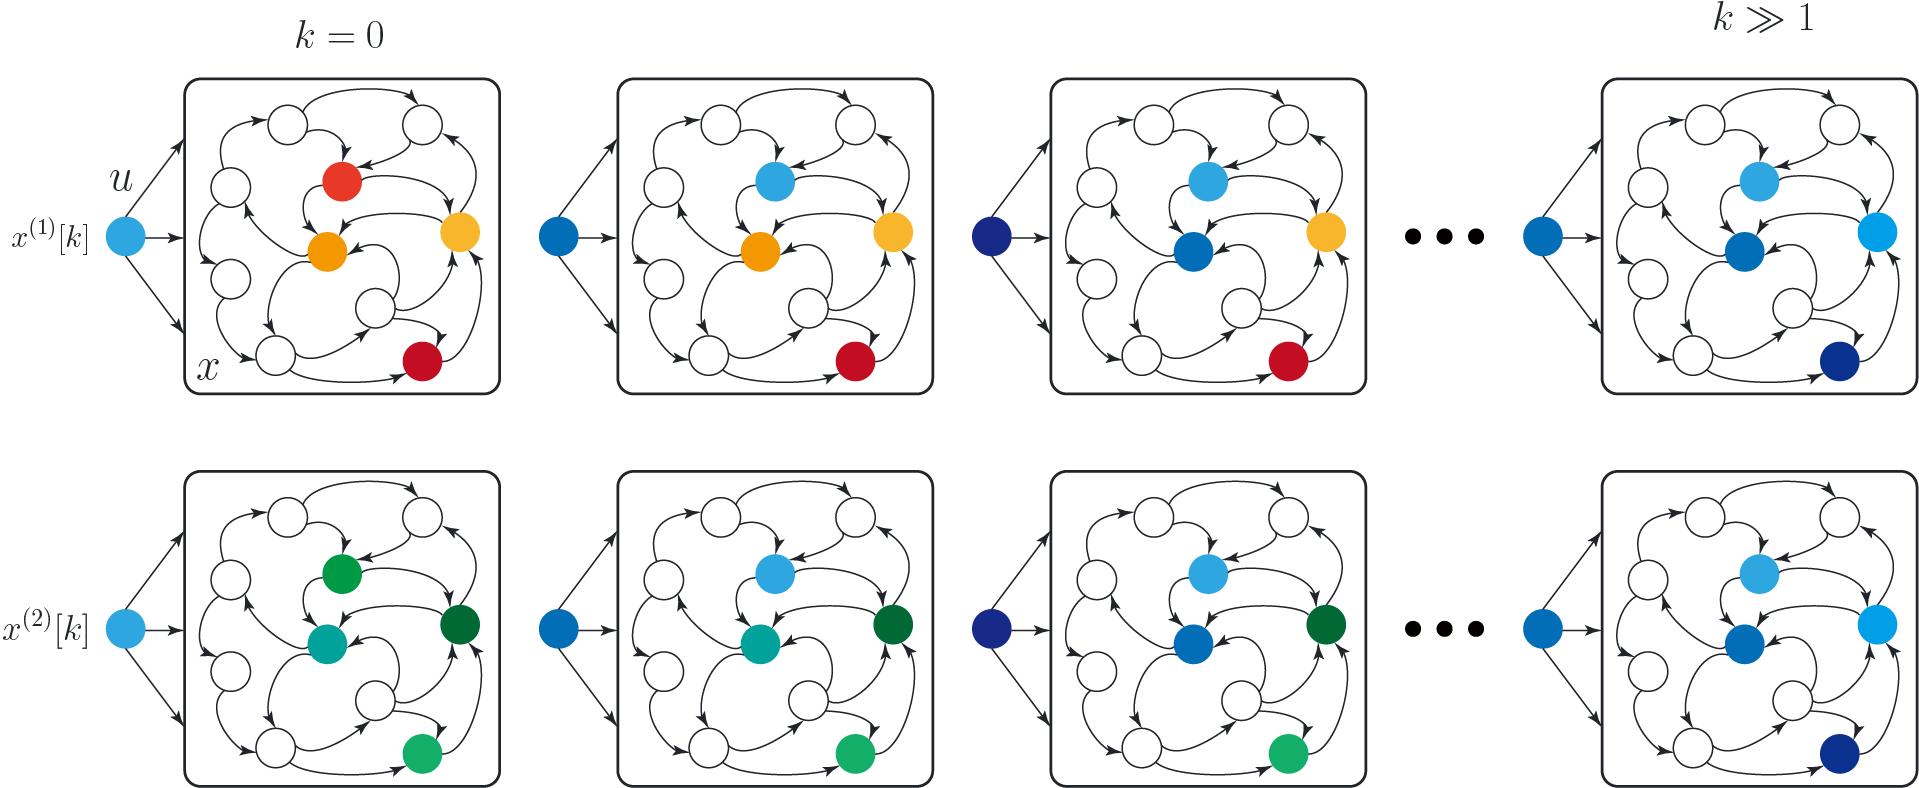
</div>

<figcaption align = "center">

図1 ESNにおける共通入力同期

</figcaption>

ESPは、この現象と密接に関わっています。
リザバーとなる力学系に同じ入力系列を何度も与えたとき、系の応答は毎回同じである必要があります。
リザバー出力は系の状態の線形和で表されるので、系の応答が毎回同じでない場合、再現的なリザバー出力が得られないからです。
これを言い換えると、状態 $x[k]$ は入力系列 (のみ) に依存する以下の関数で表現できる必要があります。

$$
\begin{align*}
x[k] = \varphi(u[k], u[k-1],~\ldots)
.\end{align*}
$$

この関数は **エコー関数 (echo function)** と呼ばれます。
系の状態がエコー関数として表現できる状況をESPといいます。
共通入力同期現象の確認によって、ESPの有無を確かめられます。時間 $t$ における2つの軌道間の距離を次のように定義します。

$$
\begin{align*}
d[k] = ||x^{(1)}[k] - x^{(2)}[k]||_2
,\end{align*}
$$

ただし、$||\cdot||_2$ は L2 ノルムです。
この距離の時間平均を以下のように定義します。

$$
\begin{align*}
\bar{d} = \frac{1}{S} \sum_{k=T-S+1}^{T} d[k]
.\end{align*}
$$

この指標は**ESP指数 (ESP index)**<sup>[12]</sup> と呼ばれ、ESPの指標とする場合があります。
ただし、$S$ は指標の計算に使う時間ステップの長さを表すパラメータです。

Q4.2.

次の空欄を埋め、ESP指数を計算する関数`calc_esp_index`を実装せよ。
引数として、2つの状態軌道をまとめて格納した多次元配列 $X = [X^{(1)}, X^{(2)}] \in \mathbb{R}^{T\times 2 \times \cdots \times N} $ および ESP指数の計算に使う時間ステップ数 $S \in \mathbb{Z}$ が与えられる。

- `calc_esp_index`
  - Argument(s):
    - `xs`: `np.ndarray`
      - `shape`: `(t, 2, ..., n)`
    - `S`: `int`
  - Return(s):
    - `d_bar`: `np.ndarray`
      - `shape`: `(...,)`

<details><summary>tips</summary>

</details>

In [ ]:
def calc_esp_index(xs, S):
    # TODO
    x1 = xs[-S:, 0]
    x2 = xs[-S:, 1]
    ds = np.linalg.norm(x1 - x2, axis=-1)
    d_bar = np.mean(ds, axis=0)
    return d_bar
    # end of TODO


test_func(calc_esp_index, "04_02")
# show_solution("04_02", "calc_esp_index")  # Uncomment it to see the solution.

以下のサンプルコードでは、ESNのスペクトル半径 $\rho$ と入力のスケーリング $\sigma$ を変数として、ガウシアンノイズを入力として与えた際の条件付きリアプノフ指数およびESP指数を計測しています。

すでに確認したとおり、$\rho$ が大きいほど最大リアプノフ指数が大きく、カオス性が強まります。
一方で、$\sigma$ が大きくなると最大リアプノフ指数は小さくなります。これは雑音誘起秩序の効果によるものです。
また、左右の図の比較によって最大リアプノフ指数とESP指数の関係が明らかになります。
最大リアプノフ指数が負もしくは $0$ 付近の場合は、初期状態の異なる軌道が離れていかないのでESP指数は $0$ に近い値を取ります。
それに対して、最大リアプノフ指数が正となるカオスの条件では、ESP指数が正の値をとり、ESPが消失しています。

In [ ]:
seed = 7778
dim = 100
rhos = np.linspace(1.0, 1.5, 11)
sigmas = np.linspace(0.0, 1.0, 11)
t_washout = 1000
t_eval = 1000
t_esp_index = 500  # S

rnd = np.random.default_rng(seed)
net = ESN(dim, sr=rhos[:, None], rnd=rnd)
w_in = Linear(1, dim, bound=1.0, rnd=rnd)
ts = np.arange(-t_washout, t_eval)
us = rnd.normal(size=(ts.shape[0], 1))
vs = w_in(us)
x0 = rnd.uniform(-1, 1, (2, len(sigmas), len(rhos), dim))
x0[1] = x0[0] + 0.001

x = x0
xs = np.zeros((ts.shape[0], *x.shape))  # (t, 2, sigmas, rhos, dim)
for idx in trange(ts.shape[0]):
    x = net(x, sigmas[:, None, None] * vs[idx])
    xs[idx] = x


esp_indexs = calc_esp_index(xs, t_esp_index)
_lmbds, cond_lyaps = calc_max_lyapunov_exponent(
    lambda x, idx: net(x, sigmas[:, None, None] * vs[t_washout + idx]),
    xs[t_washout + 1, 0],
    t_eval,
    display=True,
)

# Plotting
fig = Figure(figsize=(18, 8))
fig.create_grid(1, 2, wspace=0.5)
fig[0].plot_matrix(cond_lyaps, x=rhos, y=sigmas, zscale="centered", cmap="bwr")
fig[1].plot_matrix(esp_indexs, x=rhos, y=sigmas)
fig[0].set_xlabel(r"$\rho$")
fig[0].set_ylabel(r"$\sigma$")
fig[0].set_title("Conditional MLE")
fig[1].set_xlabel(r"$\rho$")
fig[1].set_ylabel(r"$\sigma$")
fig[1].set_title("ESP index")

None

## 参考文献

[1] Alligood, K. T., Sauer, T. D., & Yorke, J. A. (1997). *Chaos. An Introduction to Dynamical Systems*, New York: Springer-Verlag. ([訳書] 津田一郎 (監訳) (2012) 『カオス　第1〜3巻　力学系入門』 丸善出版.)

[2] Strogatz, S. H. (1994). *Nonlinear Dynamics and Chaos*, Boston: Perseus Books Publishing. ([訳書] 田中久陽, 中尾裕也, 千葉逸人 (訳) (2015) 『非線形ダイナミクスとカオス』 丸善出版.)

[3] 合原一幸, 池口徹, 山田泰司, 小室元政 (2000) 『カオス時系列解析の基礎と応用』 産業図書.

[4] Sprott, J. C. (2003). *Chaos and Time-Series Analysis*, Oxford University Press, pp.116-117. https://sprott.physics.wisc.edu/chaos/lyapexp.htm

[5] Shimada, I., & Nagashima, T. (1979). *A numerical approach to ergodic problem of dissipative dynamical systems*. Progress of theoretical physics, 61(6), 1605-1616. https://doi.org/10.1143/PTP.61.1605

[6] Matsumoto, K., & Tsuda, I. (1983). *Noise-induced order*. Journal of Statistical Physics, 31(1), 87–106. https://doi.org/10.1007/BF01010923

[7] Pecora, L. M., & Carroll, T. L. (1990). *Synchronization in chaotic systems*. Physical Review Letters, 64(8), 821–824. https://doi.org/10.1103/PhysRevLett.64.821

[8] Afraimovich, V. S., Verichev, N. N., & Rabinovich, M. I. (1986). *Stochastic synchronization of oscillation in dissipative systems*. Radiophysics and Quantum Electronics, 29(9), 795–803. https://doi.org/10.1007/BF01034476

[9] Rulkov, N. F., Sushchik, M. M., Tsimring, L. S., & Abarbanel, H. D. I. (1995). *Generalized synchronization of chaos in directionally coupled chaotic systems*. Physical Review E, 51(2), 980–994. https://doi.org/10.1103/PhysRevE.51.980

[10] Kocarev, L., & Parlitz, U. (1996). *Generalized Synchronization, Predictability, and Equivalence of Unidirectionally Coupled Dynamical Systems*. Physical Review Letters, 76(11), 1816–1819. https://doi.org/10.1103/PhysRevLett.76.1816

[11] Lu, Z., Hunt, B., & Ott, E. (2018). *Attractor reconstruction by machine learning*, Chaos: An Interdisciplinary Journal of Nonlinear Science, 28(6), 061104. https://doi.org/10.1063/1.5039508

[12] Gallicchio, C. (2019). *Chasing the Echo State Property*, ESANN 2019 Proceedings. https://www.esann.org/sites/default/files/proceedings/legacy/es2019-76.pdf